In [39]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

In [3]:
#Load dataset
df_train = pd.read_json("D:/StatoilC-CORE Iceberg Classifier Challenge/train.json/train.json")

In [4]:
#With rescaling
def prepare_data(df):
    X_band_1 = []
    X_band_2 = []
    
    for band in df["band_1"]:
        #Convert to float32
        band_1 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_1 = band_1.reshape(75,75)
        X_band_1.append(band_1)
        
    for band in df["band_2"]:
         #Convert to float32
        band_2 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_2 = band_2.reshape(75,75)
        X_band_2.append(band_2)
        
    #Convert list to numpy array
    X_band_1 = np.array(X_band_1)
    X_band_2 = np.array(X_band_2)
    
    # Rescale
    X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
    X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
    #Concatenate band_1 and band_2 to create X for training (or test)
    X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                        X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                        axis=-1)
    
    Y = np.array(df["is_iceberg"])
    
    return X, Y

In [5]:
X, Y = prepare_data(df_train)

print("X shape is:{}".format(X.shape))
print("Y shape is:{}".format(Y.shape))

X shape is:(1604, 75, 75, 3)
Y shape is:(1604,)


# Transfer learning using VGG16 as feature extraction and PCA

In [6]:
SIZE = 75

# Split data to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
# Normalize and reshape
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train = X_train / 255
X_test = X_test / 255

In [11]:
# One hot encoding
y_train_one_hot = to_categorical(Y_train)
y_test_one_hot = to_categorical(Y_test)

In [12]:
# Load VGG model
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))

In [13]:
# Make Loaded layers as non-trainable
for layer in vgg_model.layers:
    layer.trainable = False
    
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

In [15]:
# Now we want to use features from convolutional network (vgg16) for random forest model
feature_vgg16 = vgg_model.predict(X_train)
feature_vgg16 = feature_vgg16.reshape(feature_vgg16.shape[0], -1)

# PCA

### 1- PCA model with vgg16 feature

In [33]:
scaler = StandardScaler()
scaler = scaler.fit_transform(feature_vgg16)

# PCA model
pca_model = PCA(whiten=True)
# Fit the model
pca_model.fit(scaler)

PCA(whiten=True)

In [34]:
print('variation ratio: {}'.format(pca_model.explained_variance_ratio_))
print('variations: {}'.format(pca_model.explained_variance_))
print('Components: {}'.format(pca_model.components_))

variation ratio: [2.11499348e-01 1.56318799e-01 1.16528936e-01 ... 1.93163561e-16
 1.81303167e-16 3.32305617e-17]
variations: [1.5409157e+02 1.1388881e+02 8.4899200e+01 ... 1.4073271e-13 1.3209160e-13
 2.4210711e-14]
Components: [[ 2.0475090e-03  2.9802322e-08 -5.9604645e-08 ... -3.4038652e-02
  -3.6991708e-02  0.0000000e+00]
 [ 4.5583665e-02  2.9802322e-08 -5.9604645e-08 ...  6.0105152e-02
   3.8139433e-02 -0.0000000e+00]
 [ 4.1491985e-02  3.7252903e-09 -2.9802322e-08 ... -3.9318975e-02
  -5.3016510e-02  0.0000000e+00]
 ...
 [-6.3945772e-06 -8.7221460e-03 -1.1804513e-02 ...  2.4368055e-06
   1.3965182e-05  0.0000000e+00]
 [ 5.5634882e-06  6.4698067e-03  1.1769397e-02 ... -2.7526636e-05
   4.6271831e-05 -0.0000000e+00]
 [-1.2470016e-05 -6.2935483e-03  2.9761766e-04 ...  1.0926451e-05
   2.4858164e-06  0.0000000e+00]]


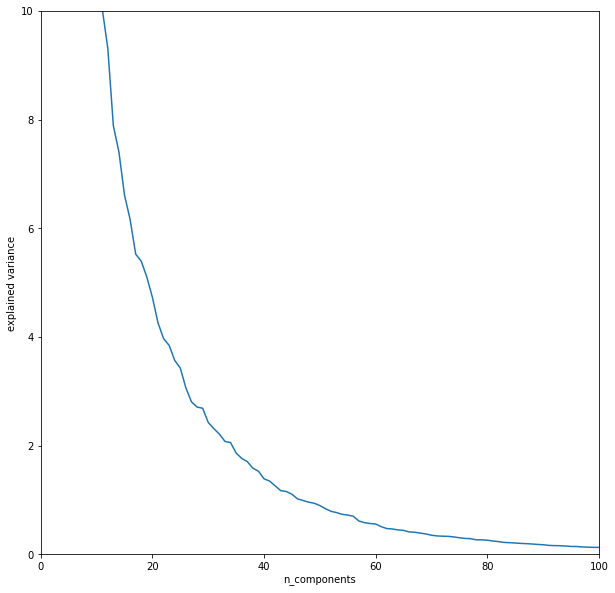

In [35]:
# Plotting
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("n_components")
ax.set_ylabel("explained variance")
ax.set_xlim(0,100)
ax.set_ylim(0,10)
ax.plot(pca_model.explained_variance_)

### 2- PCA model with vgg16 feature

In [24]:
scaler = StandardScaler()
scaler = scaler.fit_transform(feature_vgg16)

# PCA model
pca_model = PCA(n_components=2)
# Fit_transform the model
components = pca_model.fit_transform(scaler)

In [25]:
print('variation ratio: {}'.format(pca_model.explained_variance_ratio_))
print('variations: {}'.format(pca_model.explained_variance_))
print('Components: {}'.format(pca_model.components_))

variation ratio: [0.21149911 0.15631874]
variations: [154.09146 113.88881]
Components: [[ 2.04754737e-03  4.95584296e-10 -6.56284532e-12 ... -3.40386666e-02
  -3.69917229e-02  0.00000000e+00]
 [ 4.55834903e-02 -3.22572991e-09  1.05900115e-10 ...  6.01050891e-02
   3.81393880e-02  0.00000000e+00]]


In [28]:
# Show two pca components as a data frame
df = pd.DataFrame(data = components, columns = ['principal component 1', 'principal component 2'])
df.head()

,principal component 1,principal component 2
0,-14.467923,33.826923
1,-14.146217,1.853175
2,12.166386,19.900597
3,-2.532365,8.351295
4,5.620408,-13.434025


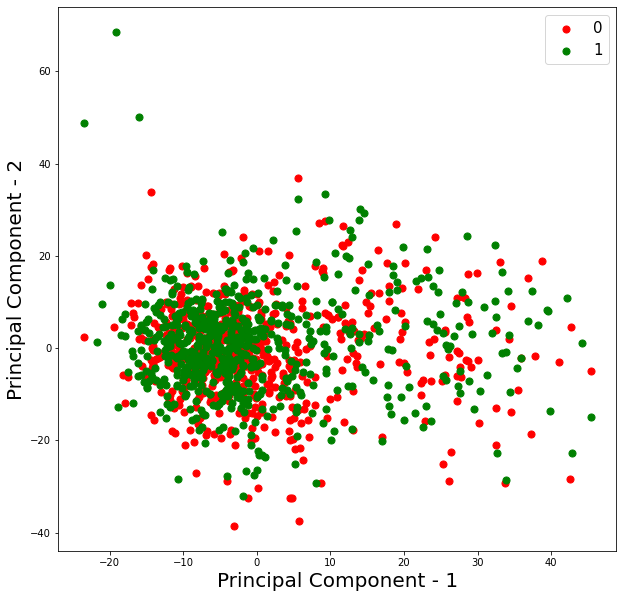

In [30]:
# Visualizing two pca components

plt.figure(figsize=(10,10))
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
colors = {0: 'r', 1:'g'}.items()
for cat, color in colors:
    plt.scatter(df.loc[df_train.is_iceberg==cat ,'principal component 1'], 
                df.loc[df_train.is_iceberg==cat ,'principal component 2'], c = color, s = 50)

plt.legend([_[0] for _ in colors],prop={'size': 15})
plt.show()

# Transfer learning using VGG19 as feature extraction and PCA

In [40]:
# Load VGG model
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))

In [41]:
# Make Loaded layers as non-trainable
for layer in vgg19_model.layers:
    layer.trainable = False
    
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

In [42]:
# Now we want to use features from convolutional network (vgg16) for random forest model
feature_vgg19 = vgg_model.predict(X_train)
feature_vgg19 = feature_vgg19.reshape(feature_vgg19.shape[0], -1)

# PCA

### 1- PCA model with vgg16 feature

In [45]:
scaler = StandardScaler()
scaler = scaler.fit_transform(feature_vgg19)

# PCA model
pca_model = PCA(whiten=True)
# Fit the model
pca_model.fit(scaler)

PCA(whiten=True)

In [46]:
print('variation ratio: {}'.format(pca_model.explained_variance_ratio_))
print('variations: {}'.format(pca_model.explained_variance_))
print('Components: {}'.format(pca_model.components_))

variation ratio: [2.11499348e-01 1.56318799e-01 1.16528936e-01 ... 1.93163561e-16
 1.81303167e-16 3.32305617e-17]
variations: [1.5409157e+02 1.1388881e+02 8.4899200e+01 ... 1.4073271e-13 1.3209160e-13
 2.4210711e-14]
Components: [[ 2.0475090e-03  2.9802322e-08 -5.9604645e-08 ... -3.4038652e-02
  -3.6991708e-02  0.0000000e+00]
 [ 4.5583665e-02  2.9802322e-08 -5.9604645e-08 ...  6.0105152e-02
   3.8139433e-02 -0.0000000e+00]
 [ 4.1491985e-02  3.7252903e-09 -2.9802322e-08 ... -3.9318975e-02
  -5.3016510e-02  0.0000000e+00]
 ...
 [-6.3945772e-06 -8.7221460e-03 -1.1804513e-02 ...  2.4368055e-06
   1.3965182e-05  0.0000000e+00]
 [ 5.5634882e-06  6.4698067e-03  1.1769397e-02 ... -2.7526636e-05
   4.6271831e-05 -0.0000000e+00]
 [-1.2470016e-05 -6.2935483e-03  2.9761766e-04 ...  1.0926451e-05
   2.4858164e-06  0.0000000e+00]]


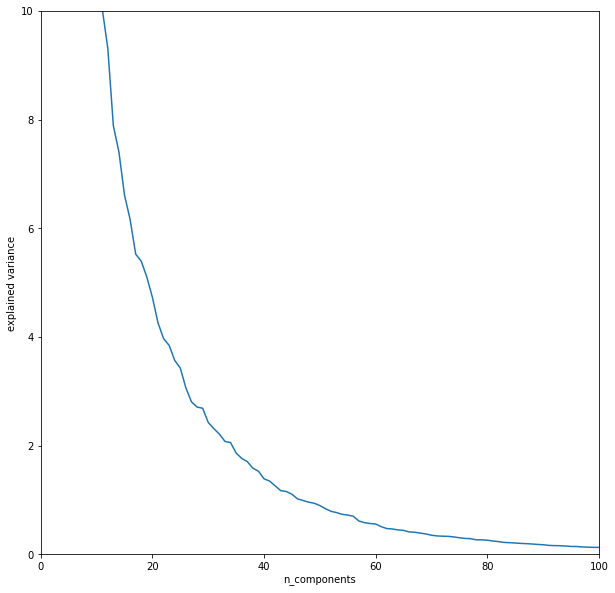

In [47]:
# Plotting
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("n_components")
ax.set_ylabel("explained variance")
ax.set_xlim(0,100)
ax.set_ylim(0,10)
ax.plot(pca_model.explained_variance_)

### 2- PCA model with vgg16 feature

In [48]:
scaler = StandardScaler()
scaler = scaler.fit_transform(feature_vgg19)

# PCA model
pca_model = PCA(n_components=2)
# Fit_transform the model
components = pca_model.fit_transform(scaler)

In [49]:
print('variation ratio: {}'.format(pca_model.explained_variance_ratio_))
print('variations: {}'.format(pca_model.explained_variance_))
print('Components: {}'.format(pca_model.components_))

variation ratio: [0.2114994  0.15631868]
variations: [154.09166 113.88877]
Components: [[ 2.0475173e-03  3.7678360e-10  1.2316659e-11 ... -3.4038667e-02
  -3.6991734e-02 -0.0000000e+00]
 [ 4.5583602e-02 -5.9894674e-08  6.7138750e-10 ...  6.0105089e-02
   3.8139399e-02  0.0000000e+00]]


In [52]:
df = pd.DataFrame(data=components, columns=["principal component 1", "principal component 2"])
df.head()

,principal component 1,principal component 2
0,-14.467928,33.826931
1,-14.146236,1.853197
2,12.166399,19.900597
3,-2.532367,8.351295
4,5.620412,-13.434021


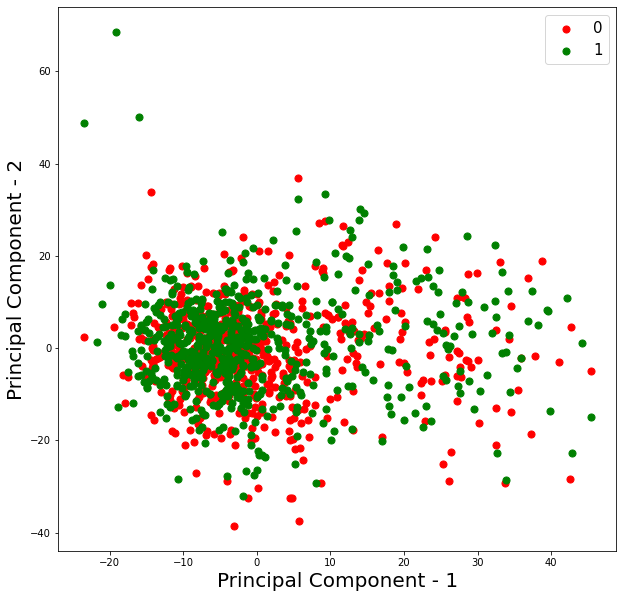

In [53]:
# Visualizing two pca components

plt.figure(figsize=(10,10))
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
colors = {0: 'r', 1:'g'}.items()
for cat, color in colors:
    plt.scatter(df.loc[df_train.is_iceberg==cat ,'principal component 1'], 
                df.loc[df_train.is_iceberg==cat ,'principal component 2'], c = color, s = 50)

plt.legend([_[0] for _ in colors],prop={'size': 15})
plt.show()